# Data Wrangling with Spark

In [111]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
spark = (SparkSession
             .builder 
             .appName("wrangling-data") 
             .getOrCreate()
)

In [4]:
path = "../data/json/sparkify_log_small.json"
user_log = spark.read.json(path)

# Data Exploration 

In [5]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [8]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [9]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [10]:
user_log.count()

10000

In [13]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [15]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").show()

+------+---------+--------+--------------------+
|userId|firstname|    page|                song|
+------+---------+--------+--------------------+
|  1046|  Kenneth|NextSong|Christmas Tears W...|
|  1046|  Kenneth|NextSong|  Be Wary Of A Woman|
|  1046|  Kenneth|NextSong|   Public Enemy No.1|
|  1046|  Kenneth|NextSong|Reign Of The Tyrants|
|  1046|  Kenneth|NextSong|      Father And Son|
|  1046|  Kenneth|NextSong|               No. 5|
|  1046|  Kenneth|NextSong|           Seventeen|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|          War on war|
|  1046|  Kenneth|NextSong|   Killermont Street|
|  1046|  Kenneth|NextSong|        Black & Blue|
|  1046|  Kenneth|  Logout|                null|
|  1046|  Kenneth|    Home|                null|
|  1046|  Kenneth|NextSong|     Heads Will Roll|
|  1046|  Kenneth|NextSong|Bleed It Out [Liv...|
|  1046|  Kenneth|NextSong|              Clocks|
|  1046|  Kenneth|NextSong|           Love Rain|
|  1046|  Kenneth|Ne

# Calculating Statistics by Hour

In [17]:
get_hour = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0).hour)

In [18]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [22]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22')

In [29]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupBy(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [30]:
songs_in_hour.show(5)

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
+----+-----+
only showing top 5 rows



In [31]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

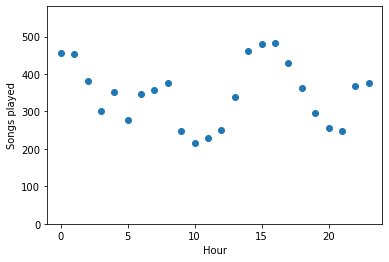

In [32]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [34]:
user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])

In [35]:
user_log_valid.count()

10000

In [38]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [39]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [40]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [75]:
user_log_valid.filter(user_log['page'] == 'Submit Downgrade').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|downgraded|phase|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  11|         1|    1|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+--

In [76]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log['userId'] == "1138").show()

+------+---------+--------+-----+--------------------+
|userId|firstname|    page|level|                song|
+------+---------+--------+-----+--------------------+
|  1138|    Kelly|    Home| paid|                null|
|  1138|    Kelly|NextSong| paid| Everybody Everybody|
|  1138|    Kelly|NextSong| paid|               Gears|
|  1138|    Kelly|NextSong| paid|        Use Somebody|
|  1138|    Kelly|NextSong| paid|Love Of My Life (...|
|  1138|    Kelly|NextSong| paid|Down In The Valle...|
|  1138|    Kelly|NextSong| paid|Treat Her Like A ...|
|  1138|    Kelly|NextSong| paid|Everybody Thinks ...|
|  1138|    Kelly|NextSong| paid|      Fourteen Wives|
|  1138|    Kelly|NextSong| paid|   Love On The Rocks|
|  1138|    Kelly|NextSong| paid|           Breakeven|
|  1138|    Kelly|NextSong| paid|          Leaf House|
|  1138|    Kelly|NextSong| paid|       NAISEN KANSSA|
|  1138|    Kelly|NextSong| paid|  You're In My Heart|
|  1138|    Kelly|NextSong| paid|Roll On Down The ...|
|  1138|  

In [151]:
flag_downgrade_event = F.udf(lambda page: 1 if page == "Submit Downgrade" else 0, T.IntegerType())

In [45]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [46]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22', downgraded=0)

In [48]:
windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [49]:
user_log_valid = user_log_valid.withColumn("phase", F.sum("downgraded").over(windowval))

In [77]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log['userId'] == "1138").sort("ts").show(100)

+------+---------+-------------+----------------+-----+-----+
|userId|firstname|           ts|            page|level|phase|
+------+---------+-------------+----------------+-----+-----+
|  1138|    Kelly|1513729066284|            Home| paid|    1|
|  1138|    Kelly|1513729066284|        NextSong| paid|    1|
|  1138|    Kelly|1513729313284|        NextSong| paid|    1|
|  1138|    Kelly|1513729552284|        NextSong| paid|    1|
|  1138|    Kelly|1513729783284|        NextSong| paid|    1|
|  1138|    Kelly|1513730001284|        NextSong| paid|    1|
|  1138|    Kelly|1513730263284|        NextSong| paid|    1|
|  1138|    Kelly|1513730518284|        NextSong| paid|    1|
|  1138|    Kelly|1513730768284|        NextSong| paid|    1|
|  1138|    Kelly|1513731182284|        NextSong| paid|    1|
|  1138|    Kelly|1513731435284|        NextSong| paid|    1|
|  1138|    Kelly|1513731695284|        NextSong| paid|    1|
|  1138|    Kelly|1513731857284|        NextSong| paid|    1|
|  1138|

# Quiz questions

**Which page did user id "" (empty string) NOT visit?**

Answer: NextSong

In [72]:
user_log.filter(user_log['userId'] == "").select("page").dropDuplicates().show()

+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



**How many female users do we have in the data set?**

Answer: 462

In [64]:
user_log.select(['userId', 'gender']).dropDuplicates().groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  462|
|     M|  501|
|  null|    1|
+------+-----+



**How many songs were played from the most played artist?**

Answer: 83

In [82]:
user_log.filter(user_log["page"] == 'NextSong').groupBy('artist').count().orderBy(F.desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|Barry Tuckwell/Ac...|   28|
|               Train|   28|
|          Lily Allen|   28|
|          Nickelback|   27|
|           Metallica|   27|
|           Daft Punk|   27|
|          Kanye West|   26|
|          John Mayer|   24|
+--------------------+-----+
only showing top 20 rows



**How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer**

Answer: 7

In [152]:
is_home = F.udf(lambda page: int(page == 'Home'), T.IntegerType())

user_window = (Window 
                   .partitionBy('userID') 
                   .orderBy(F.asc('ts')) 
                   .rangeBetween(Window.unboundedPreceding, Window.currentRow)
)

home_cum_sum = (user_log
                    .filter((user_log['page'] == 'NextSong') | (user_log['page'] == 'Home')) 
                    .select(['userID', 'page', 'ts']) 
                    .withColumn('home_visit', is_home(F.col('page'))) 
                    .withColumn('period', F.sum('home_visit').over(user_window))
)

home_cum_sum.filter(F.col('userId') == '174').show(50)

(home_cum_sum
     .filter(home_cum_sum['page'] == 'NextSong')
     .groupBy('userId', 'period') 
     .agg({'period':'count'}) 
     .agg({'count(period)':'avg'})
     .show()
)

+------+--------+-------------+----------+------+
|userID|    page|           ts|home_visit|period|
+------+--------+-------------+----------+------+
|   174|    Home|1513769153284|         1|     1|
|   174|NextSong|1513769188284|         0|     1|
|   174|NextSong|1513769485284|         0|     1|
|   174|NextSong|1513769761284|         0|     1|
|   174|NextSong|1513769961284|         0|     1|
|   174|NextSong|1513770272284|         0|     1|
|   174|NextSong|1513770488284|         0|     1|
|   174|NextSong|1513770782284|         0|     1|
|   174|NextSong|1513770979284|         0|     1|
|   174|    Home|1513834999284|         1|     2|
|   174|NextSong|1513835035284|         0|     2|
|   174|NextSong|1513835130284|         0|     2|
|   174|NextSong|1513835304284|         0|     2|
|   174|NextSong|1513835540284|         0|     2|
|   174|NextSong|1513835815284|         0|     2|
|   174|NextSong|1513836032284|         0|     2|
|   174|    Home|1513836034284|         1|     3|
